<a href="https://colab.research.google.com/github/katarinagresova/XAI_MALTAomics23/blob/dev/interpreting_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpreting Neural Networks for Computer Vision

In this notebook, we will look at several examples how to look under the hood of neural networks working with image data.

We will work with already trained model downloaded from TensorFlow, therefore all code connected with the neural network will be written in python and ThensorFlow framework.

We will use several interpretation techniques to examine the model and its prediction. We will not go into the theoretical background of interpretation methods, but links to more detailed explanations will be provided.

![](https://www.medoid.ai/wp-content/uploads/2022/06/IML-2-1024x576.png) (source: https://www.medoid.ai/)

# 1. Setup



## 1.1. Imports

In [1]:
!pip install shap -q

In [2]:
import tensorflow as tf
import keras

import requests
from PIL import Image
from io import BytesIO

import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import random
import shap
from shap.plots.colors import red_transparent_blue

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## 1.2. Definitions

In [3]:
model_builder = keras.applications.xception.Xception
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

img_size = (299, 299)

last_conv_layer_name = "block14_sepconv2_act"

In [4]:
images_for_test_map = {
    "tiger": "https://upload.wikimedia.org/wikipedia/commons/b/b0/Bengal_tiger_%28Panthera_tigris_tigris%29_female_3_crop.jpg",
    "bus": "https://upload.wikimedia.org/wikipedia/commons/6/63/LT_471_%28LTZ_1471%29_Arriva_London_New_Routemaster_%2819522859218%29.jpg",
    "car": "https://upload.wikimedia.org/wikipedia/commons/4/49/2013-2016_Toyota_Corolla_%28ZRE172R%29_SX_sedan_%282018-09-17%29_01.jpg",
    "cat": "https://upload.wikimedia.org/wikipedia/commons/4/4d/Cat_November_2010-1a.jpg",
    "dog": "https://upload.wikimedia.org/wikipedia/commons/archive/a/a9/20090914031557%21Saluki_dog_breed.jpg",
    "cat_and_dog": "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg",
    "african_elephant": "https://i.imgur.com/Bvro0YD.png",
    "apple": "https://upload.wikimedia.org/wikipedia/commons/1/15/Red_Apple.jpg",
    "banana": "https://upload.wikimedia.org/wikipedia/commons/1/1c/Bananas_white_background.jpg",
    "turtle": "https://upload.wikimedia.org/wikipedia/commons/8/80/Turtle_golfina_escobilla_oaxaca_mexico_claudio_giovenzana_2010.jpg",
    "flamingo": "https://upload.wikimedia.org/wikipedia/commons/b/b8/James_Flamingos_MC.jpg",
    "piano": "https://upload.wikimedia.org/wikipedia/commons/d/da/Steinway_%26_Sons_upright_piano%2C_model_K-132%2C_manufactured_at_Steinway%27s_factory_in_Hamburg%2C_Germany.png",
    "honeycomb": "https://upload.wikimedia.org/wikipedia/commons/f/f7/Honey_comb.jpg",
    "teapot": "https://upload.wikimedia.org/wikipedia/commons/4/44/Black_tea_pot_cropped.jpg",
    "fireboat": "https://upload.wikimedia.org/wikipedia/commons/0/06/A_Portland_fireboat_-a.jpg"
}

## 1.3. Helper functions

In [5]:
def load_image(image_name, size):
    img_path = keras.utils.get_file(
      image_name + ".jpg", images_for_test_map[image_name]
    )
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    # `img_array` is preprocessed input for Xception neural net
    img_array = preprocess_input(array)

    return img_array, img

def show_image(image, title=''):
  image_size = image.shape[1]
  w = (image_size * 6) // 320
  plt.figure(figsize=(w, w))
  plt.imshow(image[0], aspect='equal')
  plt.axis('off')
  plt.title(title)
  plt.show()

def decode_preds(preds, top=3):
  labels = decode_predictions(preds, top=top)
  inds = preds[0].argsort()[-top:][::-1]

  for pred in range(top):
      print('%s (%.2f%%), id: %d' % (labels[0][pred][1], labels[0][pred][2]*100, inds[pred]))

def normalize(image):
    norm = (image - image.mean())/image.std()
    norm = norm * 0.1
    norm = norm + 0.5
    norm = norm.clip(0, 1)
    return norm

## 1.4. Input data

There are several images prepared in the `images_for_test_map`. You can use them by selecting one of the options from the following selection:

`['tiger', 'bus', 'car', 'cat', 'dog', 'cat_and_dog', 'african_elephant', 'apple', 'banana', 'turtle', 'flamingo', 'piano', 'honeycomb', 'teapot', 'fireboat']`

We need to specify the image size to reshape the image into the shape required by the neural network model.

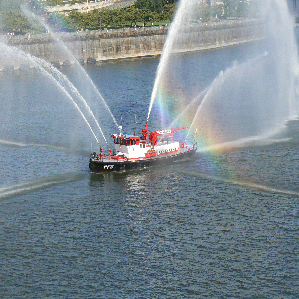

In [6]:
# `img_array` is for the input of neural network and `img` is for displaing

img_array, img = load_image(image_name="fireboat", size=img_size)
img

## Exercise 1: Add custom image

In the **Definitions** sections, there is variable `images_for_test_map` with pairs **image name** and **image url**. You can find your own image and add it to the `images_for_test_map`.

In [7]:
# TODO: load your custom image

## 1.5. Model

In this notebook, we will work with the [Xception](https://keras.io/api/applications/xception/) neural network trained on the [ImageNet](https://www.image-net.org/) dataset.

We can use Keras interface to load trained model. There are several useful default parameters:

```python
keras.applications.Xception(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
```
and the only thing we need to specify is the `input_shape`. We will use images `299x299` pixels and the depth is `3` since we are working with the RGB images.

In [8]:
# model_builder was set to keras.applications.xception.Xception in the definitions
# img_size was set to (299, 299) in helper functions

model = model_builder(
    input_shape=(img_size[0], img_size[1], 3)
)

To get the prediction from the model, we need to call the model object with the input data encoded as an array. Input needs to have dimensions `(1, 299, 299, 3)`, where `1` is the number of images in the batch, `(299, 299)` is the width and height of an image and `3` is the depth of RGB image. We have defined this width and height of image as an `input_shape` of a model and we also resized our images to match these dimensions.

Exception model was trained to classify images into `1000` categories. Predictions returned from the model are therefore in the form of array of `1000` probabilities - each number is a probability that an imput image belongs to a given class. Thensorflow also provides a function to map output probabilities into class names. In the definitions, we have defined

`decode_predictions = keras.applications.xception.decode_predictions`

as a decoder function for our Xception model. There is also additional `decode_preds()` function in the Helper functions that prints a nicely formated results.

In [9]:
preds = model(img_array).numpy()
decode_preds(preds, top=3)

fireboat (92.29%), id: 554
fire_engine (0.12%), id: 555
liner (0.08%), id: 628


# 2. Brief intro to CNNs and convolution

Convolutional Neural Networks (CNNs) are a class of deep learning models primarily used for tasks related to image analysis and computer vision. They are designed to automatically and adaptively learn hierarchical patterns and features from images.

![](https://miro.medium.com/v2/resize:fit:1000/1*z7hd8FZeI_eodazwIapvAw.png)

At the core of a CNN are convolutional layers. These layers consist of small filters or kernels that slide (convolve) over the input image. Each filter performs a convolution operation by multiplying its weights with a small portion of the input image and summing the results. This process extracts local patterns and features, such as edges or textures, from the image. Multiple filters are used in each convolutional layer to capture various features. Weights of the filters are learned during the training of neural network therefore individual filters holds information about important features in the input.

![](https://miro.medium.com/v2/resize:fit:700/1*D6iRfzDkz-sEzyjYoVZ73w.gif)

CNNs also incorporate pooling layers, typically max-pooling or average-pooling, which downsample the feature maps produced by the convolutional layers. Pooling helps reduce the spatial dimensions of the feature maps while retaining the most important information, making the network more computationally efficient and invariant to small translations in the input.

Finally, fully connected layers are often used at the end of the CNN to perform classification or regression tasks. These layers take the high-level features learned from the previous layers and use them to make predictions. The entire CNN is trained using backpropagation and gradient descent to optimize its parameters, allowing it to learn and recognize complex patterns and objects within images.

For deeper explanation of convolution and CNNs, look at [CNN explainer](https://poloclub.github.io/cnn-explainer/) website.

## 2.1. CNN filters and visual cortex of a cat

![](https://www.researchgate.net/publication/335707980/figure/fig1/AS:803803662127107@1568653135830/Fig-In-the-classic-neuroscience-experiment-Hubel-and-Wiesel-discovered-a-cats-visual.png)

Neurophysiologists David Hubel and Torsten Wiesel were conducting experiments on cats when they discovered that similar parts of an image, as well as simple shapes, caused similar parts of the cats' brains to become active. In other words, when a cat looks at a circle, the A-zone is activated in its brain. When it looks at a square, however, the brain's B-zone is activated. These findings were used in their work on the principles of how visual systems function. Later, they confirmed these ideas with practical information.
Their conclusions sounded something like the following: animals' brains contain a zone of neurons which react to the specific characteristics of an image. And each and every image passes through a so-called feature extractor before entering the deepest parts of the brain.

tl;dr;

Convolutional neural networks and animal brains have similar baseline processes - first, input image is decomposed into simple patterns that are hierarchicaly conected together in the following layers to inderstand the conctent of input image.

# 3. Interpretation

In the previous sections, we saw our model in the action - it was recognizing objects in images. Now we will dig deeper to better understand how can the model distinguish cats from dogs and apples from bananas.

We will look at several interpretation techniques that can be divided into two classes:
1. Methods for interpreting models, and
2. Methods for interpreting decisions.

In the class of methods for interpreting models, we will visualize individual kernels learned by neural network and we will apply these kernels on input images to see what features do they extract.

In the class of methods for interpreting decisions, we will examine individual images and see which parts of the image were important for the models decision. We will look at the following methods:
1. Grad-CAM
2. Guided Backpropagation
3. Integrated Gradients

## 3.1. Kernel visualization

One way to interpret models is to examine the properties of the kernels in the convolutional layers. Weight of kernels are being learned in the process of training, therefore they can hold information about important features in the input image.


In [10]:
def extract_kernel(model, L=1, CH=0, K=0):
  # Get the L-th convolutional layer from the model
  c1 = model.layers[L]

  if not isinstance(c1, keras.src.layers.convolutional.conv2d.Conv2D):
    print(f"Error: Layer {L} is not a convolutional layer. Pick a different layer")
    return

  # Get the weights of the L-th convolutional layer
  weights1 = c1.get_weights()

  # Pull out the CH-th channel of the K-th kernel in the L-th layer
  kernel = weights1[0][..., CH, K]

  return kernel

In [11]:
kernel = extract_kernel(model)

Kernel:
[[ 0.4018715   0.3894546   0.4157912 ]
 [-0.11647206 -1.2329519  -0.75004053]
 [-0.05341647 -1.5801911  -0.9605914 ]]

Shape:  (3, 3)



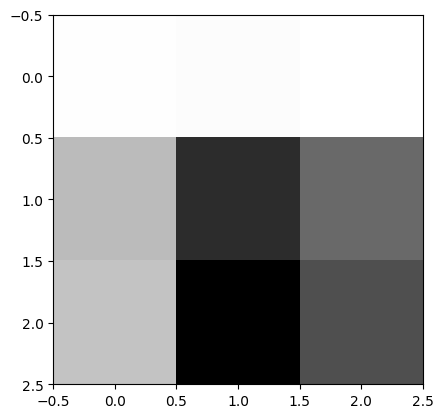

In [12]:
print("Kernel:")
print(kernel)
print()
print("Shape: ", kernel.shape)
print()
plt.imshow(kernel, cmap='gray');

**Note:** we will return to kernel visualization in the following section, where we will use it for discovering sequence motifs in genomic sequences.

### 3.1.1. Visualize feature maps

The activation maps, called feature maps, capture the result of applying the filters to input, such as the input image or another feature map.

The idea of visualizing a feature map for a specific input image would be to understand what features of the input are detected or preserved in the feature maps. The expectation would be that the feature maps close to the input detect small or fine-grained detail, whereas feature maps close to the output of the model capture more general features.

In [13]:
def convolution(image, kernel):
    kernel = kernel - kernel.mean()
    result = np.zeros(image.shape)
    kernel_size = kernel.shape[0]

    for ii in range(image.shape[0]-kernel_size):
        for jj in range(image.shape[1]-kernel_size):
            result[ii, jj] = np.sum(image[ii:ii+kernel_size, jj:jj+kernel_size] * kernel)

    return result

In [14]:
def plot_comparison(img_original, img_filtered, img_title_filtered, gray=True):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 8), sharex=True, sharey=True)

    #img_filtered = img_filtered.resize((img_original.shape[1], img_original.shape[0]))

    if gray:
      ax1.imshow(img_original, cmap='gray')
    else:
      ax1.imshow(img_original)
    ax1.set_title('Original')
    ax1.axis('off')
    if gray:
      ax2.imshow(img_filtered, cmap='gray')
    else:
      ax2.imshow(img_filtered)
    ax2.set_title(img_title_filtered)
    ax2.axis('off')

In [15]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

gray_image = rgb2gray(img_array[0, :, :, :])

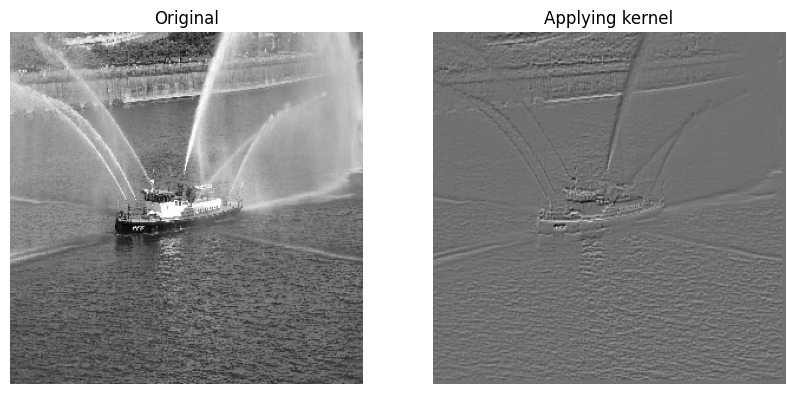

In [16]:
# Convolve with the image
out = convolution(gray_image, kernel)
plot_comparison(gray_image, out, 'Applying kernel')

## Excercise 2: Design kernel

In [17]:
## define custom 3x3 kernel array

## plot the kernel

## convolve the image with your kernel

## plot the result

## 3.2. Grad-CAM

Gradient-weighted Class Activation Mapping (Grad-CAM), uses the gradients of any target concept (say ‘dog’ in a classification network or a sequence of words in captioning network) flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept. For deeper understanding and more examples, follow this [article](https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353).

In [18]:
class GradCam():
    def __init__(self, model):
        self.model = model

    def __call__(self, input, pred_index=None, last_conv_layer_name=None):
        if last_conv_layer_name == 'all':
            return self._make_all_layer_gradcam(input, pred_index)

        if last_conv_layer_name is None:
            last_conv_layer_name = self._get_last_conv_layer_name()

        return self._make_gradcam(input, pred_index, last_conv_layer_name)

    def _make_gradcam(self, input, pred_index, last_conv_layer_name):
        # First, we create a model that maps the input image to the activations
        # of the last conv layer as well as the output predictions
        grad_model = tf.keras.models.Model(
            [self.model.inputs], [self.model.get_layer(last_conv_layer_name).output, self.model.output]
        )

        # Then, we compute the gradient of the top predicted class for our input image
        # with respect to the activations of the last conv layer
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(input)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]

        # This is the gradient of the output neuron (top predicted or chosen)
        # with regard to the output feature map of the last conv layer
        grads = tape.gradient(class_channel, last_conv_layer_output)

        # This is a vector where each entry is the mean intensity of the gradient
        # over a specific feature map channel
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # We multiply each channel in the feature map array
        # by "how important this channel is" with regard to the output class
        # then sum all the channels to obtain the heatmap class activation
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        # For visualization purpose, we will also normalize the heatmap between 0 & 1
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()

    def _make_all_layer_gradcam(self, input, pred_index):
        #layers = [layer.name for layer in reversed(self.model.layers) if len(layer.output_shape) == 4 and (layer.__class__.__name__ == 'ReLU' or isinstance(layer, tf.keras.layers.convolutional.conv2d.Conv2D) or isinstance(layer, ResBlock))]
        layers = [layer.name for layer in reversed(self.model.layers) if len(layer.output_shape) == 4]
        cams = []
        for layer in layers:
            cam = self._make_gradcam(input, pred_index, layer)
            cam = cv2.resize(cam, (input.shape[2], input.shape[1]))
            cams.append(cam)
        return np.mean(cams, axis=0)

    def _get_last_conv_layer_name(self):
        layers = [layer.name for layer in reversed(self.model.layers) if len(layer.output_shape) == 4 and (isinstance(layer, tf.keras.layers.Conv2D))]# or isinstance(layer, ResBlock))]
        #layers = [layer.name for layer in reversed(self.model.layers)]
        return layers[0]

In [19]:
gradcam = GradCam(model)
map = gradcam(img_array, last_conv_layer_name=last_conv_layer_name)

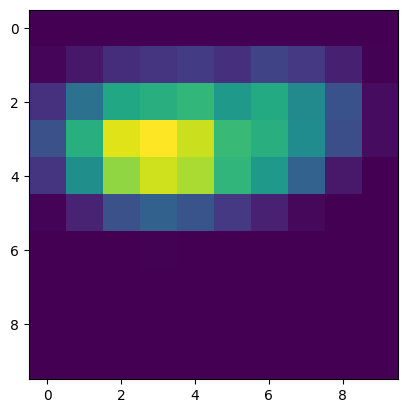

In [20]:
plt.imshow(map)

In [21]:
# grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
(w, h) = (img_array.shape[2], img_array.shape[1])
heatmap = cv2.resize(map, (w, h))
# normalize the heatmap such that all values lie in the range
# [0, 1], scale the resulting values to the range [0, 255],
# and then convert to an unsigned 8-bit integer
numer = heatmap - np.min(heatmap)
denom = (heatmap.max() - heatmap.min())
heatmap = numer / denom

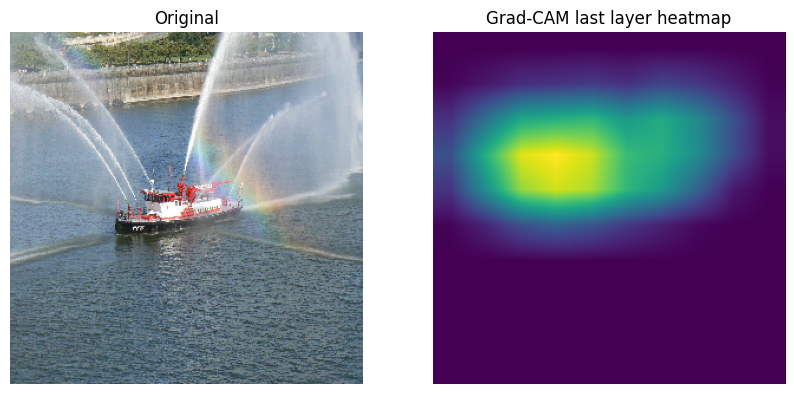

In [22]:
plot_comparison(img, heatmap, 'Grad-CAM last layer heatmap', gray=False)

In [23]:
map_all = gradcam(img_array, last_conv_layer_name="all")

In [24]:
# grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
(w, h) = (img_array.shape[2], img_array.shape[1])
heatmap_all = cv2.resize(map_all, (w, h))
# normalize the heatmap such that all values lie in the range
# [0, 1], scale the resulting values to the range [0, 255],
# and then convert to an unsigned 8-bit integer
numer = heatmap_all - np.min(heatmap_all)
denom = (heatmap_all.max() - heatmap_all.min())
heatmap_all = numer / denom

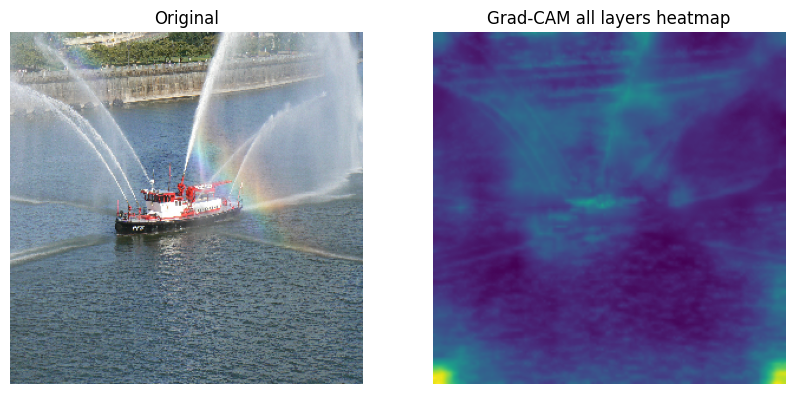

In [25]:
plot_comparison(img, heatmap_all, 'Grad-CAM all layers heatmap', gray=False)

## Excercise 3: Image and heatmap on top of eachother

It could be better to plot the heatmap on top of the image to ideantify exact places in the image that were important for the model.

In [26]:
## plot the heatmap on top of the image
## make the image grayscale for better visualization
## make the heatmap transparent to see the image trough it

## 3.3. Guided Backpropagation

Guided backpropagation is a technique that allows us to determine which input features are responsible for a particular output value in a neural network model. It is a modified version of backpropagation, which is a technique used to train deep learning models. In backpropagation, we compute the gradients of the loss function with respect to the weights of the model. These gradients are then used to update the weights of the model during the training process.

Guided backpropagation modifies the backpropagation algorithm to compute the gradients of the output with respect to the input instead of the weights. This allows us to determine which input features are responsible for a particular output value. Guided backpropagation achieves this by applying a positive gradient to the input features that are responsible for a particular output value and a negative gradient to the input features that are not responsible for that output value.

For further explanation and Pytorch implementation, look at this [article](https://leslietj.github.io/2020/07/22/Deep-Learning-Guided-BackPropagation/).

In [27]:
@tf.custom_gradient
def guided_relu(x):
    # guided version of relu which lets back only postive gradients in backpropogation
    def grad(dy):
        return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy

    return tf.nn.relu(x), grad

class GuidedBackprop:
    def __init__(self, model):
        self.model = model
        self.gb_model = self.build_guided_model()

    def build_guided_model(self):

        # build a guided version of the model replace ReLU with guided ReLU
        gb_model = tf.keras.Model(
            self.model.inputs, self.model.output
        )
        layers = [
            layer for layer in gb_model.layers[1:] if hasattr(layer, "activation")
        ]
        for layer in layers:
            if layer.activation == tf.keras.activations.relu:
                layer.activation = guided_relu
        return gb_model

    def guided_backprop(self, image: np.ndarray, class_index: int, num_classes: int):
        # convert to one hot representation to match our softmax activation in the model definition
        expected_output = tf.one_hot([class_index] * image.shape[0], num_classes)
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            tape.watch(inputs)
            outputs = self.gb_model(inputs)
            loss = tf.keras.losses.binary_crossentropy(
                expected_output, outputs
            )
        # get the gradient of the loss with respect to the input image
        grads = tape.gradient(loss, inputs)[0]
        return grads

In [28]:
preds = model.predict(img_array)
top_pred_idx = tf.argmax(preds[0])

gb = GuidedBackprop(model)
saliency_map = gb.guided_backprop(img_array, top_pred_idx, preds.size).numpy()
saliency_map = normalize(saliency_map)

1/1 [==============================] - 1s 1s/step


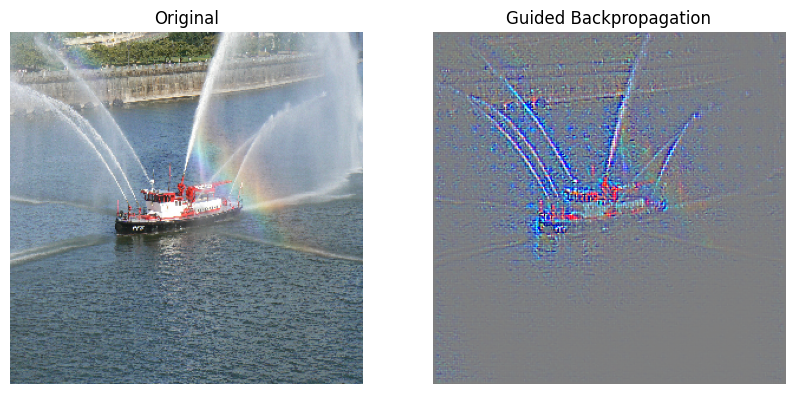

In [29]:
plot_comparison(img, saliency_map, 'Guided Backpropagation', gray=False)

## 3.4. Integrated Gradients

[Integrated Gradients](https://arxiv.org/abs/1703.01365) is a technique for attributing a classification model's prediction to its input features. It is a model interpretability technique: you can use it to visualize the relationship between input features and model predictions.

Integrated Gradients is a variation on computing the gradient of the prediction output with regard to features of the input. To compute integrated gradients, we need to perform the following steps:

Identify the input and the output. In our case, the input is an image and the output is the last layer of our model (dense layer with softmax activation).

Compute which features are important to a neural network when making a prediction on a particular data point. To identify these features, we need to choose a baseline input. A baseline input can be a black image (all pixel values set to zero) or random noise. The shape of the baseline input needs to be the same as our input image, e.g. (299, 299, 3).

Interpolate the baseline for a given number of steps. The number of steps represents the steps we need in the gradient approximation for a given input image. The number of steps is a hyperparameter. The authors recommend using anywhere between 20 and 1000 steps.

Preprocess these interpolated images and do a forward pass.

Get the gradients for these interpolated images.
Approximate the gradients integral using the trapezoidal rule.
To read in-depth about integrated gradients and why this method works, consider reading this excellent [article](https://distill.pub/2020/attribution-baselines/).

In [30]:
# implementation based on https://keras.io/examples/vision/integrated_gradients/

def get_gradients(model, img_input, top_pred_idx):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        img_input: 4D image tensor
        top_pred_idx: Predicted label for the input image

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    images = tf.cast(img_input, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
        top_class = preds[:, top_pred_idx]

    grads = tape.gradient(top_class, images)
    return grads


def get_integrated_gradients(model, img_input, pred_idx=None, baseline=None, num_steps=50):
    """Computes Integrated Gradients for a label.

    Args:
        img_input (ndarray): Original image
        pred_idx: Label to compute integrated gradients for
        baseline (ndarray): The baseline image to start with for interpolation
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.

    Returns:
        Integrated gradients w.r.t input image
    """
    # If baseline is not provided, start with a black image
    # having same size as the input image.
    if baseline is None:
        baseline = np.zeros(img_size).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    # 1. Do interpolation.
    img_input = img_input.astype(np.float32)
    interpolated_image = [
        baseline + (step / num_steps) * (img_input - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_image = np.array(interpolated_image).astype(np.float32)

    # 2. Preprocess the interpolated images
    interpolated_image = preprocess_input(interpolated_image)

    # 3. Get the gradients
    grads = []
    for i, img in enumerate(interpolated_image):
        img = tf.expand_dims(img, axis=0)
        grad = get_gradients(model, img, top_pred_idx=top_pred_idx)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (img_input - baseline) * avg_grads
    return integrated_grads


def random_baseline_integrated_gradients(
    model, img_input, top_pred_idx, num_steps=50, num_runs=2
):
    """Generates a number of random baseline images.

    Args:
        img_input (ndarray): 3D image
        top_pred_idx: Predicted label for the input image
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        num_runs: number of baseline images to generate

    Returns:
        Averaged integrated gradients for `num_runs` baseline images
    """
    # 1. List to keep track of Integrated Gradients (IG) for all the images
    integrated_grads = []

    # 2. Get the integrated gradients for all the baselines
    for run in range(num_runs):
        baseline = np.random.random(img_input.shape) * 255
        igrads = get_integrated_gradients(
            model=model,
            img_input=img_input,
            pred_idx=top_pred_idx,
            baseline=baseline,
            num_steps=num_steps,
        )
        integrated_grads.append(igrads)

    # 3. Return the average integrated gradients for the image
    integrated_grads = tf.convert_to_tensor(integrated_grads)
    return tf.reduce_mean(integrated_grads, axis=0)

In [31]:
array = keras.utils.img_to_array(img)
orig_img = np.copy(array).astype(np.uint8)

# Get model predictions
preds = model.predict(img_array)
top_pred_idx = tf.argmax(preds[0])
print("Predicted:", top_pred_idx, decode_predictions(preds, top=1)[0])

# define new model to avoid confusion of guided relu from guided backpropagation
model = model_builder(
    input_shape=(img_size[0], img_size[1], 3)
)

# Get the integrated gradients
igrads = random_baseline_integrated_gradients(
    model, np.copy(orig_img), top_pred_idx=top_pred_idx, num_steps=50, num_runs=2
)

1/1 [==============================] - 0s 46ms/step
Predicted: tf.Tensor(554, shape=(), dtype=int64) [('n03344393', 'fireboat', 0.9229134)]


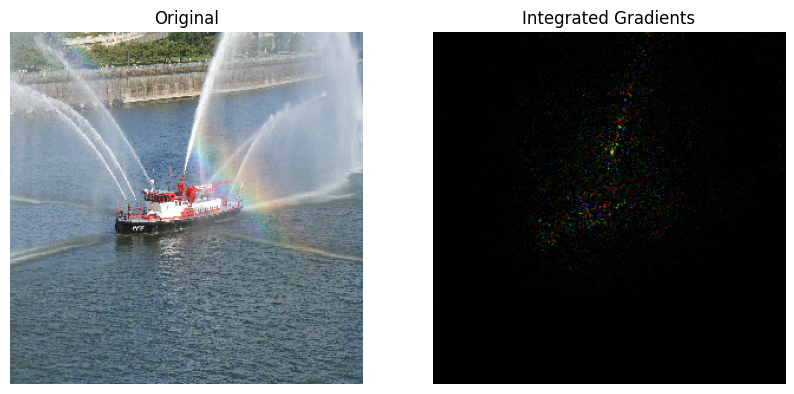

In [32]:
plot_comparison(orig_img, igrads, 'Integrated Gradients', gray=False)

In [33]:
# Taking a matrix of size 5 as the kernel
kernel = np.ones((5, 5), np.uint8)
dilated_igrads = cv2.dilate(igrads.numpy(), kernel=kernel)

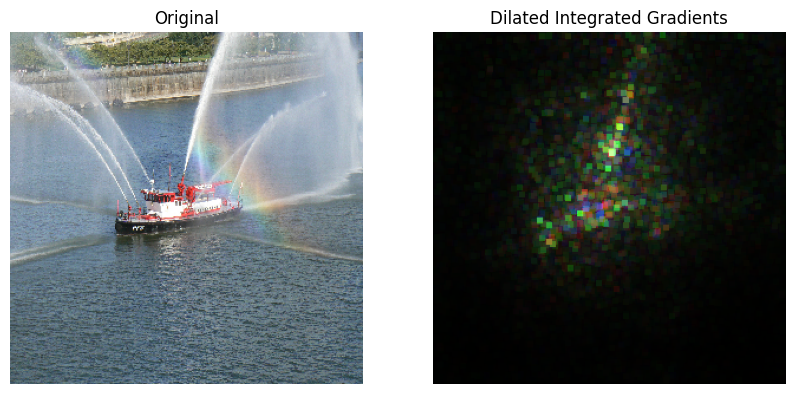

In [34]:
plot_comparison(orig_img, dilated_igrads, 'Dilated Integrated Gradients', gray=False)

## Excercise 4: Experiment with baselines

In the example above, we have used `random_baseline_integrated_gradients()` where the baseline was randomly generated noise. You can try different baselines, for example:
- white image
- black image
- random noise with a different distribution
- blurred input image
- different input image